In [1]:
import numpy as np
import pandas as pd
import math

import xarray as xr
import parflow as pf
from parflow.tools.io import read_pfb

import matplotlib.pyplot as plt
# DTT, from MMF's R script

In [2]:
###################################
# File locations and inputs
# Latitude_pf = np.squeeze(read_pfb('/glade/p/univ/ucsm0009/CONUS2/domain_files/Latitude_CONUS2.pfb'))
# Longitude_pf = np.squeeze(read_pfb('/glade/p/univ/ucsm0009/CONUS2/domain_files/Longitude_CONUS2.pfb'))
Latitude_pf = np.squeeze(read_pfb('/hydrodata/national_mapping/CONUS2/Latitude_CONUS2.pfb'))
Longitude_pf = np.squeeze(read_pfb('/hydrodata/national_mapping/CONUS2/Longitude_CONUS2.pfb'))

# Path to GHCND file with list of observations and years available
ghcnd_inventory_path = "/glade/p/univ/ucsm0002/CONUS_modern/Analysis_Validation/Validation/GHCND_MetStations/ghcnd-inventory.txt"

# Path to GHCND file with list of stations 
ghcnd_stations_path = "/glade/p/univ/ucsm0002/CONUS_modern/Analysis_Validation/Validation/GHCND_MetStations/ghcnd-stations.txt"

# Water years you want included when choosing stations
# NOTE: GHCND file inventory uses calendar years, not water years
start = 2002 # start water year
end = 2003 # end water year
yrs = list(range(start,end+1))

# # Path to lat/lon grid file
# CONUSlatlon = latlon = np.loadtxt('/glade/p/univ/ucsm0002/CONUS2/domain_files/CONUS2.0.Final.LatLong.sa',skiprows=1)

# Output file 
# this will be a csv containing list of stations for comparison:
# station ID, lat/lon of station, station name, station elevation,
# availability of core variables - TMIN/TAVG/TMAX/PRCP/WESD/SNOW/SNWD/AWND,
# and the CONUS index, x-index and y-index for comparison cells

print(f'Water Years to include for GHCND: {yrs}')

Water Years to include for GHCND: [2002, 2003]


In [3]:
###################################
# Read in station data

# Reading these in as fixed width 
ghcnd_inventory = pd.read_fwf(ghcnd_inventory_path,
                           names = ["ID","LATITUDE","LONGITUDE","ELEMENT","FIRSTYEAR","LASTYEAR"])

ghcnd_stations = pd.read_fwf(ghcnd_stations_path,
                            names = ["ID","LATITUDE","LONGITUDE","ELEVATION_m","STATE","NAME","GSN_FLAG","HCN_FLAG","WMO_ID"])#,comment='$') 

In [4]:
print(ghcnd_stations.shape)
ghcnd_stations

(115081, 9)


,ID,LATITUDE,LONGITUDE,ELEVATION_m,STATE,NAME,GSN_FLAG,HCN_FLAG,WMO_ID
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,NaN,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,NaN,GSN,41196.0,NaN
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,NaN,NaN,41194.0,NaN
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,NaN,NaN,41217.0,NaN
...,...,...,...,...,...,...,...,...,...
115076,ZI000067969,21.0500,29.3670,861.0,WEST NICHOLSON,NaN,NaN,67969.0,NaN
115077,ZI000067975,20.0670,30.8670,1095.0,MASVINGO,NaN,NaN,67975.0,NaN
115078,ZI000067977,21.0170,31.5830,430.0,BUFFALO RANGE,NaN,NaN,67977.0,NaN
115079,ZI000067983,20.2000,32.6160,1132.0,CHIPINGE,NaN,GSN,67983.0,NaN


In [5]:
###################################
# Dataframe to fill

# N Rows = number of unique station IDs
# N Columns = 16:
# - Station ID
# - Station Name
# - Station Lat
# - Station Lon
# - Station Elevation
# - CONUS index (PF index)
# - CONUS x index
# - CONUS y index
# - TMIN availability
# - TAVG availability
# - TMAX availability
# - PRCP availability
# - WESD availability
# - SNOW availability
# - SNWD availability
# - AWND availability

# First, to make this a bit more efficient, do a cursory look at stations
# and remove all that are outside of a bounding box containing CONUS2
# maxlat = math.ceil(CONUSlatlon[:,0].max())
# minlat = math.floor(CONUSlatlon[:,0].min())
# maxlon = math.ceil(CONUSlatlon[:,1].max())
# minlon = math.floor(CONUSlatlon[:,1].min())

# maxlat = Latitude_pf.max()
# minlat = Latitude_pf.min()
# maxlon = Longitude_pf.max()
# minlon = Longitude_pf.min()

### CONUS 1 Bounding Box
### Need to update this, but doing this now because the `extract_station_indices_in_parflow_grid` function won't work when 
### lat/lon does NOT correspond to a CONUS2 grid cell (i.e. if the lat/long is WITHIN the bounding box, but OUTSIDE of the active domain)
maxlat = 51
minlat = 30
maxlon = -75
minlon = -122

out_domain1 = np.where((ghcnd_stations.LATITUDE > maxlat) | (ghcnd_stations.LATITUDE < minlat))
out_domain2 = np.where((ghcnd_stations.LONGITUDE > maxlon) | (ghcnd_stations.LONGITUDE < minlon))
out_domain = np.union1d(out_domain1[0], out_domain2[0])
# stations contained within CONUS2 bounding box
ghcnd_stations = ghcnd_stations.drop(out_domain)

In [6]:
print(type(ghcnd_stations))
ghcnd_stations = ghcnd_stations.set_index('ID')
ghcnd_stations

<class 'pandas.core.frame.DataFrame'>


,LATITUDE,LONGITUDE,ELEVATION_m,STATE,NAME,GSN_FLAG,HCN_FLAG,WMO_ID
ID,,,,,,,,
CA005010140,49.2833,-99.3000,450.0,BALDUR,NaN,NaN,NaN,NaN
CA005010143,49.4167,-99.1667,425.0,BALDUR 5 NORTHEAST,NaN,NaN,NaN,NaN
CA005010190,49.4000,-99.4333,447.0,BELMONT,NaN,NaN,NaN,NaN
CA005010191,49.3000,-99.4500,482.0,BELMONT,NaN,NaN,NaN,NaN
CA005010480,49.9167,-99.9500,409.0,BRANDON A,NaN,NaN,71140.0,NaN
...,...,...,...,...,...,...,...,...
USW00094992,47.7472,-90.3444,185.9,GRAND MARAIS,NaN,NaN,NaN,NaN
USW00094993,45.6689,-96.9914,353.9,SISSETON MUNI AP,NaN,NaN,NaN,NaN
USW00094994,43.1561,-90.6775,204.8,BOSCOBEL AP,NaN,NaN,NaN,NaN


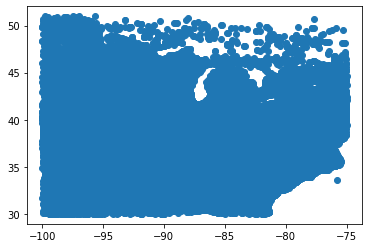

In [7]:
plt.scatter(ghcnd_stations['LONGITUDE'],ghcnd_stations['LATITUDE'])

In [8]:
from extract_CONUS2_indices import *

##CREATE DICT WITH THE LOCATIONS OF STATIONS

my_station_locations = {}
#my_station_locations = ghcnd_stations_latlon.to_dict

#my_station_locations['ID']=[lat,lon]
#my_station_locations['AR000087007']=[49.2833,-99.3000]
## Create dictionary from GHCND Station Locations
for i in range(len(ghcnd_stations.index)):
    my_station_locations[ghcnd_stations.index[i]]=[ghcnd_stations.LATITUDE[i],ghcnd_stations.LONGITUDE[i]]

Finished finding CONUS2 indices


In [ ]:
dictionary_of_rows_cols = extract_station_indices_in_parflow_grid(my_station_locations, Latitude_pf, Longitude_pf)


### Create dataframe from dictionary containing CONUS2 x and y indices

In [ ]:
conus2_index_for_sites = pd.DataFrame.from_dict(dictionary_of_rows_cols, orient = 'index', columns = ['CONUS_y', 'CONUS_x'])
conus2_index_for_sites.index.names = ['ID']

In [ ]:
conus2_index_for_sites.head()
conus2_index_for_sites.to_csv('GHCND_mapped_CONUS2.csv')

In [ ]:
ghcnd_mapped = ghcnd_stations.join(conus2_index_for_sites)

In [ ]:
ghcnd_mapped

In [ ]:
ghcnd_mapped.to_csv('GHCND_stations_full_WITH_INDICES.csv')

# Start of next section: Find GHCND stations with available data

In [3]:
# Water years you want included when choosing stations
# NOTE: GHCND file inventory uses calendar years, not water years
start = 2002 # start water year
end = 2003 # end water year
yrs = list(range(start,end+1))

print(f'Water Years to include for GHCND: {yrs}')

Water Years to include for GHCND: [2002, 2003]


In [4]:
# read in files from above
# GHCND stations within CONUS2 (NOW CONUS1!!!) domain
ghcnd_mapped = pd.read_csv('GHCND_stations_full_WITH_INDICES.csv')

In [5]:
# clean up df (state was ignored in the pd.read_fwf() function, so removing this for now)
ghcnd_mapped = ghcnd_mapped.rename(columns = {'STATE':'STN_NAME'})
ghcnd_mapped = ghcnd_mapped.drop(columns = ['NAME'])
ghcnd_mapped = ghcnd_mapped.set_index('ID')

In [6]:
ghcnd_mapped.head()

,LATITUDE,LONGITUDE,ELEVATION_m,STN_NAME,GSN_FLAG,HCN_FLAG,WMO_ID,CONUS_y,CONUS_x
ID,,,,,,,,,
CA005010140,49.2833,-99.3000,450.0,BALDUR,NaN,NaN,NaN,2669,2046
CA005010143,49.4167,-99.1667,425.0,BALDUR 5 NORTHEAST,NaN,NaN,NaN,2683,2056
CA005010190,49.4000,-99.4333,447.0,BELMONT,NaN,NaN,NaN,2682,2037
CA005010191,49.3000,-99.4500,482.0,BELMONT,NaN,NaN,NaN,2671,2036
CA005010480,49.9167,-99.9500,409.0,BRANDON A,NaN,71140.0,NaN,2738,2003


In [6]:
### Read in GHCND Inventory Information
# Path to GHCND file with list of observations and years available
ghcnd_inventory_path = "/glade/p/univ/ucsm0002/CONUS_modern/Analysis_Validation/Validation/GHCND_MetStations/ghcnd-inventory.txt"

# Reading these in as fixed width 
ghcnd_inventory = pd.read_fwf(ghcnd_inventory_path,
                           names = ["ID","LATITUDE","LONGITUDE","ELEMENT","FIRSTYEAR","LASTYEAR"])
ghcnd_inventory = ghcnd_inventory.set_index('ID')

In [7]:
ghcnd_inventory

,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
ID,,,,,
ACW00011604,17.1167,-61.7833,TMAX,1949,1949
ACW00011604,17.1167,-61.7833,TMIN,1949,1949
ACW00011604,17.1167,-61.7833,PRCP,1949,1949
ACW00011604,17.1167,-61.7833,SNOW,1949,1949
ACW00011604,17.1167,-61.7833,SNWD,1949,1949
...,...,...,...,...,...
ZI000067983,20.2000,32.6160,PRCP,1951,2018
ZI000067983,20.2000,32.6160,TAVG,1962,2019
ZI000067991,22.2170,30.0000,TMAX,1951,1990


In [8]:
# GHCND Inventory subset by the station data within CONUS2 domain
inventory_sub = ghcnd_inventory[ghcnd_inventory.index.isin(ghcnd_mapped.index)]

In [9]:
inventory_sub

,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
ID,,,,,
CA005010140,49.2833,-99.3000,TMAX,1963,2020
CA005010140,49.2833,-99.3000,TMIN,1963,2020
CA005010140,49.2833,-99.3000,PRCP,1962,2020
CA005010140,49.2833,-99.3000,SNOW,1962,2020
CA005010140,49.2833,-99.3000,SNWD,1982,2020
...,...,...,...,...,...
USW00094995,40.8483,-96.5650,TMIN,2002,2020
USW00094995,40.8483,-96.5650,PRCP,2002,2020
USW00094996,40.6953,-96.8542,TMAX,2002,2020


In [25]:
# Find GHCND Station IDs with data for years of interest and PRECIPITATION, save dataframe
inventory_sub_prcp = inventory_sub.loc[(inventory_sub['FIRSTYEAR']<=yrs[0]) 
                                     & (inventory_sub['LASTYEAR']>=yrs[1]) 
                                     & (inventory_sub['ELEMENT']=='PRCP')] 
inventory_sub_prcp.to_csv(f'GHCND_stations_PRCP_CONUSmapped_{yrs[0]}-{yrs[1]}.csv')

In [26]:
# Find GHCND Station IDs with data for years of interest and PRECIPITATION, save dataframe
inventory_sub_tavg = inventory_sub.loc[(inventory_sub['FIRSTYEAR']<=yrs[0]) 
                                     & (inventory_sub['LASTYEAR']>=yrs[1]) 
                                     & (inventory_sub['ELEMENT']=='TAVG')]
inventory_sub_prcp.to_csv(f'GHCND_stations_TAVG_CONUSmapped_{yrs[0]}-{yrs[1]}.csv')

# Temperature comparison

In [7]:
inventory_sub_tavg = pd.read_csv('GHCND_stations_TAVG_CONUSmapped_2002-2003.csv')
inventory_sub_tavg = inventory_sub_tavg.set_index('ID')

In [8]:
inventory_sub_tavg

,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
ID,,,,,
CA005010140,49.2833,-99.3000,PRCP,1962,2020
CA005010191,49.3000,-99.4500,PRCP,1984,2016
CA005010480,49.9167,-99.9500,PRCP,1941,2012
CA005010485,49.8667,-99.9833,PRCP,1890,2009
CA005010524,50.0167,-99.5667,PRCP,1987,2003
...,...,...,...,...,...
USW00094992,47.7472,-90.3444,PRCP,1998,2020
USW00094993,45.6689,-96.9914,PRCP,1998,2020
USW00094994,43.1561,-90.6775,PRCP,1999,2020


In [12]:
# filter the stations mapped to CONUS2 indices ('GHCND_stations_full_WITH_INDICES.csv')
# that have average temperature for the time period of interest ('GHCND_stations_TAVG_CONUSmapped_2002-2003.csv')
ghcnd_mapped_tavg = ghcnd_mapped[ghcnd_mapped.index.isin(inventory_sub_tavg.index)]
ghcnd_mapped_tavg

,LATITUDE,LONGITUDE,ELEVATION_m,STN_NAME,GSN_FLAG,HCN_FLAG,WMO_ID,CONUS_y,CONUS_x
ID,,,,,,,,,
CA005010140,49.2833,-99.3000,450.0,BALDUR,NaN,NaN,NaN,2669,2046
CA005010191,49.3000,-99.4500,482.0,BELMONT,NaN,NaN,NaN,2671,2036
CA005010480,49.9167,-99.9500,409.0,BRANDON A,NaN,71140.0,NaN,2738,2003
CA005010485,49.8667,-99.9833,363.0,BRANDON CDA,NaN,NaN,NaN,2733,2001
CA005010524,50.0167,-99.5667,392.0,BROOKDALE,NaN,NaN,NaN,2748,2030
...,...,...,...,...,...,...,...,...,...
USW00094992,47.7472,-90.3444,185.9,GRAND MARAIS,NaN,NaN,NaN,2521,2688
USW00094993,45.6689,-96.9914,353.9,SISSETON MUNI AP,NaN,NaN,NaN,2278,2208
USW00094994,43.1561,-90.6775,204.8,BOSCOBEL AP,NaN,NaN,NaN,2028,2703


### Reading GHCND daily data .dly files

In [43]:
# 1-11   Character
# YEAR         12-15   Integer
# MONTH        16-17   Integer
# ELEMENT      18-21   Character
# VALUE1       22-26   Integer
# MFLAG1       27-27   Character
# QFLAG1       28-28   Character
# SFLAG1       29-29   Character
# VALUE2       30-34   Integer
# MFLAG2       35-35   Character
# QFLAG2       36-36   Character
# SFLAG2       37-37
cols = [(1,11),(12,15),(16,17),(18,21),(22,26),(27,27)]

test = pd.read_fwf('/hydrodata/temp/CONUS2_transfers/CONUS2/Validation/GHCND/ghcnd_all/CA005010140.dly', colspecs=cols)
                   #names = ["ID","YEAR","MONTH","ELEMENT","FIRSTYEAR"]

In [35]:
test

,A005010140,962,4,RCP,9999
0,A005010140,962,4,NOW,9999
1,A005010140,962,5,RCP,0
2,A005010140,962,5,NOW,0
3,A005010140,962,6,RCP,0
4,A005010140,962,6,NOW,0
...,...,...,...,...,...
3340,A005010140,23,4,MIN,-135
3341,A005010140,23,4,RCP,50
3342,A005010140,23,4,NOW,50
3343,A005010140,23,4,NWD,0
